In [ ]:
import os
import warnings

import lightgbm as lgb

import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the path to the file you'd like to load
file_path = "/content/drive/MyDrive/AI_Challenge/APPA_sample_data.csv"

df = pd.read_csv(file_path)

print("First 5 records:", df.head())

First 5 records:           Stazione Inquinante        Data  Ora  Valore Unità di misura  \
0  Parco S. Chiara       PM10  01/01/2023    0    54.0          ug.m-3   
1  Parco S. Chiara       PM10  01/01/2023    1    69.0          ug.m-3   
2  Parco S. Chiara       PM10  01/01/2023    2    66.0          ug.m-3   
3  Parco S. Chiara       PM10  01/01/2023    3    65.0          ug.m-3   
4  Parco S. Chiara       PM10  01/01/2023    4    49.0          ug.m-3   

   Latitudine  Longitudine Nazione Comune  ... Pioggia (mm)  Pioggia (mm).1  \
0    46.06292      11.1262   Italy   APPA  ...          0.0             0.0   
1    46.06292      11.1262   Italy   APPA  ...          0.0             0.0   
2    46.06292      11.1262   Italy   APPA  ...          0.0             0.0   
3    46.06292      11.1262   Italy   APPA  ...          0.0             0.0   
4    46.06292      11.1262   Italy   APPA  ...          0.0             0.0   

   Temp. aria (°C)  Temp. aria (°C).1  Temp. aria (°C).2  \
0  

In [ ]:
df = df[df['Inquinante'] == 'PM10'].copy()
display(df.head())
print(df.shape)

stations_dfs = {station: data for station, data in df.groupby('Stazione')}

for elem in stations_dfs:
  print(elem)
  #print(stations_dfs[elem].head())
  print(stations_dfs[elem].shape)
  #print(stations_dfs[elem].dtypes)


,Stazione,Inquinante,Data,Ora,Valore,Unità di misura,Latitudine,Longitudine,Nazione,Comune,...,Pioggia (mm),Pioggia (mm).1,Temp. aria (°C),Temp. aria (°C).1,Temp. aria (°C).2,Umid.relat. aria (%),Pressione atm. (hPa),Dir. Vento (°),Vel. Vento (m/s),Rad.Sol.Tot. (kJ/m2)
0,Parco S. Chiara,PM10,01/01/2023,0,54.0,ug.m-3,46.06292,11.1262,Italy,APPA,...,0.0,0.0,8.0,6.3,11.4,80.3,992.9,15.0,1.1,1738.6
1,Parco S. Chiara,PM10,01/01/2023,1,69.0,ug.m-3,46.06292,11.1262,Italy,APPA,...,0.0,0.0,8.0,6.3,11.4,80.3,992.9,15.0,1.1,1738.6
2,Parco S. Chiara,PM10,01/01/2023,2,66.0,ug.m-3,46.06292,11.1262,Italy,APPA,...,0.0,0.0,8.0,6.3,11.4,80.3,992.9,15.0,1.1,1738.6
3,Parco S. Chiara,PM10,01/01/2023,3,65.0,ug.m-3,46.06292,11.1262,Italy,APPA,...,0.0,0.0,8.0,6.3,11.4,80.3,992.9,15.0,1.1,1738.6
4,Parco S. Chiara,PM10,01/01/2023,4,49.0,ug.m-3,46.06292,11.1262,Italy,APPA,...,0.0,0.0,8.0,6.3,11.4,80.3,992.9,15.0,1.1,1738.6


(4473, 21)
A22 (Avio)
(190, 21)
Parco S. Chiara
(1434, 21)
Rovereto
(1413, 21)
Via Bolzano
(1436, 21)


In [ ]:
stations_dfs.pop('A22 (Avio)')

,Stazione,Inquinante,Data,Ora,Valore,Unità di misura,Latitudine,Longitudine,Nazione,Comune,...,Pioggia (mm),Pioggia (mm).1,Temp. aria (°C),Temp. aria (°C).1,Temp. aria (°C).2,Umid.relat. aria (%),Pressione atm. (hPa),Dir. Vento (°),Vel. Vento (m/s),Rad.Sol.Tot. (kJ/m2)
17195,A22 (Avio),PM10,22/02/2023,0,94.0,ug.m-3,45.74215,10.97043,Italy,APPA,...,0.0,0.0,7.0,3.4,12.3,83.8,936.0,345.0,0.6,7476.2
17196,A22 (Avio),PM10,22/02/2023,1,93.0,ug.m-3,45.74215,10.97043,Italy,APPA,...,0.0,0.0,7.0,3.4,12.3,83.8,936.0,345.0,0.6,7476.2
17197,A22 (Avio),PM10,22/02/2023,2,88.0,ug.m-3,45.74215,10.97043,Italy,APPA,...,0.0,0.0,7.0,3.4,12.3,83.8,936.0,345.0,0.6,7476.2
17198,A22 (Avio),PM10,22/02/2023,3,90.0,ug.m-3,45.74215,10.97043,Italy,APPA,...,0.0,0.0,7.0,3.4,12.3,83.8,936.0,345.0,0.6,7476.2
17199,A22 (Avio),PM10,22/02/2023,4,94.0,ug.m-3,45.74215,10.97043,Italy,APPA,...,0.0,0.0,7.0,3.4,12.3,83.8,936.0,345.0,0.6,7476.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17380,A22 (Avio),PM10,01/03/2023,19,37.0,ug.m-3,45.74215,10.97043,Italy,APPA,...,4.6,2.9,2.9,-0.6,7.3,74.7,935.5,44.0,0.9,4719.1
17381,A22 (Avio),PM10,01/03/2023,20,38.0,ug.m-3,45.74215,10.97043,Italy,APPA,...,4.6,2.9,2.9,-0.6,7.3,74.7,935.5,44.0,0.9,4719.1
17382,A22 (Avio),PM10,01/03/2023,21,35.0,ug.m-3,45.74215,10.97043,Italy,APPA,...,4.6,2.9,2.9,-0.6,7.3,74.7,935.5,44.0,0.9,4719.1
17383,A22 (Avio),PM10,01/03/2023,22,36.0,ug.m-3,45.74215,10.97043,Italy,APPA,...,4.6,2.9,2.9,-0.6,7.3,74.7,935.5,44.0,0.9,4719.1


In [ ]:
for elem in stations_dfs:
  print(elem)
  #print(stations_dfs[elem].head())
  print(stations_dfs[elem].shape)
  #print(stations_dfs[elem].dtypes)

Parco S. Chiara
(1434, 21)
Rovereto
(1413, 21)
Via Bolzano
(1436, 21)


In [ ]:
# Apply datetime parsing and feature engineering
for station, data in stations_dfs.items():
    data['Data'] = pd.to_datetime(data['Data'], format="%d/%m/%Y")
    data['datetime'] = data['Data'] + pd.to_timedelta(data['Ora'], unit='h')


# Reindex to have a complete time series
for station, data in stations_dfs.items():
    # Create a complete time range for the station
    if 'datetime' in data.columns:
        start_time = data['datetime'].min()
        end_time = data['datetime'].max()
        data = data.set_index('datetime', drop=False) # Keep datetime as a column
    else: # datetime is already the index
        start_time = data.index.min()
        end_time = data.index.max()

    all_hours = pd.date_range(start=start_time, end=end_time, freq='h')

    # Reindex the data with the complete time range
    stations_dfs[station] = data.reindex(all_hours)

# Display shapes to confirm
for elem in stations_dfs:
  print(elem)
  print(stations_dfs[elem].shape)

Parco S. Chiara
(1440, 22)
Rovereto
(1440, 22)
Via Bolzano
(1440, 22)


In [ ]:
for station, data in stations_dfs.items():
    data['Anno']  = data['datetime'].dt.year
    data['Mese'] = data['datetime'].dt.month
    data['Giorno']   = data['datetime'].dt.day
    data['dow']   = data['datetime'].dt.dayofweek
    # cyclical
    data['Ora_sin'] = np.sin(2*np.pi*data['datetime'].dt.hour/24)
    data['Ora_cos'] = np.cos(2*np.pi*data['datetime'].dt.hour/24)
    data['Mese_sin'] = np.sin(2*np.pi*data['Mese']/12)
    data['Mese_cos'] = np.cos(2*np.pi*data['Mese']/12)
    data['dow_sin'] = np.sin(2*np.pi*data['dow']/7)
    data['dow_cos'] = np.cos(2*np.pi*data['dow']/7)

    stations_dfs[station] = data.drop(['dow'], axis=1, inplace=False)

In [ ]:
for elem in stations_dfs:
  print(elem)
  print(stations_dfs[elem].head())
  #print(stations_dfs[elem].shape)
  #print(stations_dfs[elem].dtypes)

Parco S. Chiara
                            Stazione Inquinante       Data  Ora  Valore  \
2023-01-01 00:00:00  Parco S. Chiara       PM10 2023-01-01  0.0    54.0   
2023-01-01 01:00:00  Parco S. Chiara       PM10 2023-01-01  1.0    69.0   
2023-01-01 02:00:00  Parco S. Chiara       PM10 2023-01-01  2.0    66.0   
2023-01-01 03:00:00  Parco S. Chiara       PM10 2023-01-01  3.0    65.0   
2023-01-01 04:00:00  Parco S. Chiara       PM10 2023-01-01  4.0    49.0   

                    Unità di misura  Latitudine  Longitudine Nazione Comune  \
2023-01-01 00:00:00          ug.m-3    46.06292      11.1262   Italy   APPA   
2023-01-01 01:00:00          ug.m-3    46.06292      11.1262   Italy   APPA   
2023-01-01 02:00:00          ug.m-3    46.06292      11.1262   Italy   APPA   
2023-01-01 03:00:00          ug.m-3    46.06292      11.1262   Italy   APPA   
2023-01-01 04:00:00          ug.m-3    46.06292      11.1262   Italy   APPA   

                     ...            datetime    Anno  Mese

In [ ]:
#for station, data in stations_dfs.items():
#    print(f"Rows with NaN values for {station}:")
#    display(data[data.isnull().any(axis=1)])

In [ ]:
# Dictionary of old and new column names
new_column_names = {
    'Stazione': 'Station',
    'Inquinante': 'Pollutant',
    'Data': 'Date',
    'Ora': 'Hour',
    'Valore': 'PM10',
    'Unità di misura': 'Unit of Measure',
    'Latitudine': 'Latitude',
    'Longitudine': 'Longitude',
    'Nazione': 'Country',
    'Comune': 'Municipality',
    'Pioggia (mm)': 'Rain',
    'Pioggia (mm).1': 'Rain.1',
    'Temp. aria (°C)': 'Air Temp',
    'Temp. aria (°C).1': 'Air Temp.1',
    'Temp. aria (°C).2': 'Air Temp.2',
    'Umid.relat. aria (%)': 'Humidity',
    'Pressione atm. (hPa)': 'Pressure',
    'Dir. Vento (°)': 'Wind Direction',
    'Vel. Vento (m/s)': 'Wind Speed',
    'Rad.Sol.Tot. (kJ/m2)': 'Radiation',
    'datetime': 'Datetime',
    'Anno': 'Year',
    'Giorno': 'Day',
    'Mese': 'Month'

}


for station, data in stations_dfs.items():
    stations_dfs[station] = data.rename(columns=new_column_names)
    stations_dfs[station].drop(['Unit of Measure', 'Country', 'Municipality','Pollutant','Latitude','Longitude'], axis=1, inplace=True)

# Display the columns of one dataframe to verify
for station, data in stations_dfs.items():
    print(f"Columns of {station} after renaming:")
    print(stations_dfs[station].columns)


Columns of Parco S. Chiara after renaming:
Index(['Station', 'Date', 'Hour', 'PM10', 'StazioneMeteo', 'Rain', 'Rain.1',
       'Air Temp', 'Air Temp.1', 'Air Temp.2', 'Humidity', 'Pressure',
       'Wind Direction', 'Wind Speed', 'Radiation', 'Datetime', 'Year',
       'Month', 'Day', 'Ora_sin', 'Ora_cos', 'Mese_sin', 'Mese_cos', 'dow_sin',
       'dow_cos'],
      dtype='object')
Columns of Rovereto after renaming:
Index(['Station', 'Date', 'Hour', 'PM10', 'StazioneMeteo', 'Rain', 'Rain.1',
       'Air Temp', 'Air Temp.1', 'Air Temp.2', 'Humidity', 'Pressure',
       'Wind Direction', 'Wind Speed', 'Radiation', 'Datetime', 'Year',
       'Month', 'Day', 'Ora_sin', 'Ora_cos', 'Mese_sin', 'Mese_cos', 'dow_sin',
       'dow_cos'],
      dtype='object')
Columns of Via Bolzano after renaming:
Index(['Station', 'Date', 'Hour', 'PM10', 'StazioneMeteo', 'Rain', 'Rain.1',
       'Air Temp', 'Air Temp.1', 'Air Temp.2', 'Humidity', 'Pressure',
       'Wind Direction', 'Wind Speed', 'Radiation', 

In [ ]:
for station, data in stations_dfs.items():
    # Wind Direction (assuming 360 degrees)
    #data['wind_dir_sin'] = np.sin(2 * np.pi * data['Wind Direction'] / 360)
    #data['wind_dir_cos'] = np.cos(2 * np.pi * data['Wind Direction'] / 360)

    # Wind Speed (assuming a maximum speed or scaling appropriately)
    # For simplicity, let's just take sine and cosine directly, but a more robust approach might involve scaling
    # data['wind_speed_sin'] = np.sin(data['Wind Speed (m/s)'])
    # data['wind_speed_cos'] = np.cos(data['Wind Speed (m/s)'])
    # A common approach for wind speed is to decompose into U and V components
    data['Wind_u'] = data['Wind Speed'] * np.sin(np.deg2rad(data['Wind Direction']))
    data['Wind_v'] = data['Wind Speed'] * np.cos(np.deg2rad(data['Wind Direction']))


    stations_dfs[station] = data.drop(['Wind Direction', 'Wind Speed'], axis=1, inplace=False)

# Display the columns of one dataframe to verify
for station, data in stations_dfs.items():
    print(f"Columns of {station} after transformation:")
    print(stations_dfs[station].columns)
    break # Only print for one station for brevity

Columns of Parco S. Chiara after transformation:
Index(['Station', 'Date', 'Hour', 'PM10', 'StazioneMeteo', 'Rain', 'Rain.1',
       'Air Temp', 'Air Temp.1', 'Air Temp.2', 'Humidity', 'Pressure',
       'Radiation', 'Datetime', 'Year', 'Month', 'Day', 'Ora_sin', 'Ora_cos',
       'Mese_sin', 'Mese_cos', 'dow_sin', 'dow_cos', 'Wind_u', 'Wind_v'],
      dtype='object')


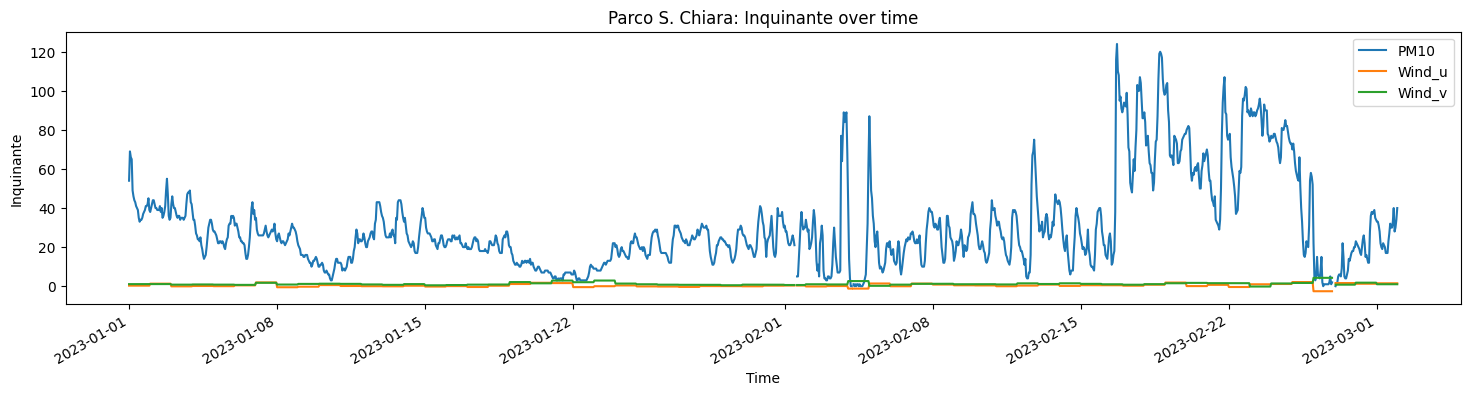

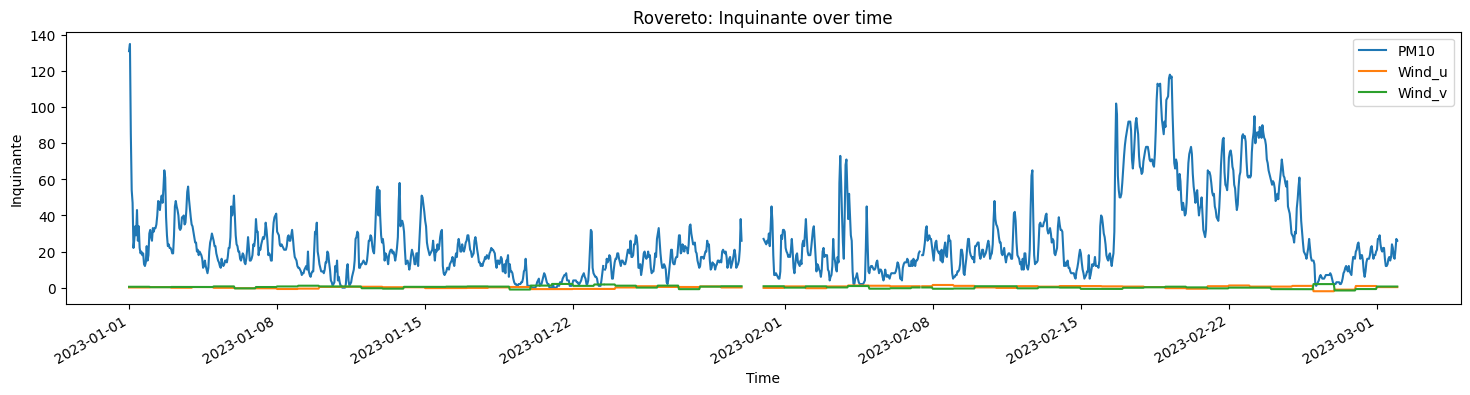

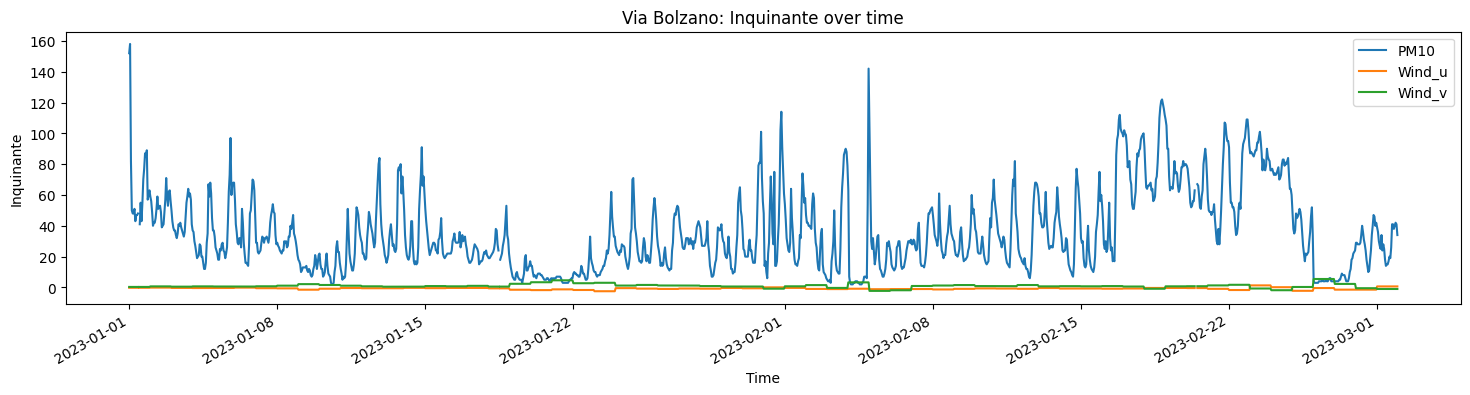

In [ ]:
for elem in stations_dfs:
    plt.figure(figsize=(18, 4))
    stations_dfs[elem].plot(x='Datetime', y='PM10', ax=plt.gca())
    stations_dfs[elem].plot(x='Datetime', y='Wind_u', ax=plt.gca())
    stations_dfs[elem].plot(x='Datetime', y='Wind_v', ax=plt.gca())
    plt.title(f'{elem}: Inquinante over time')
    plt.xlabel('Time')
    plt.ylabel('Inquinante')
    plt.show()


In [ ]:
# Create lagged features for specific columns with a lag of 6 hours
lag_period = 6

# Update column names to match the renamed columns in your dataframes
cols_to_lag = ['Radiation','Air Temp', 'Air Temp.1', 'Air Temp.2', 'Humidity', 'Pressure', 'Wind_u', 'Wind_v','PM10', 'Rain.1','Rain']


for station, data in stations_dfs.items():
    for col in cols_to_lag:
        data[f'{col}_lag_{lag_period}'] = data[col].shift(lag_period)
    stations_dfs[station] = data

# Calculate rolling mean and standard deviation for specific columns
window_size = 6

# Update column names to match the renamed columns in your dataframes
cols_to_roll = ['Radiation','Air Temp', 'Air Temp.1', 'Air Temp.2', 'Humidity', 'Pressure', 'Wind_u', 'Wind_v','PM10', 'Rain.1','Rain']


for station, data in stations_dfs.items():
    for col in cols_to_roll:
        data[f'{col}_rolling_mean_{window_size}'] = data[col].rolling(window=window_size).mean()
        data[f'{col}_rolling_std_{window_size}'] = data[col].rolling(window=window_size).std()
    stations_dfs[station] = data

# Display the head of one dataframe to verify
first_station = list(stations_dfs.keys())[0]
display(stations_dfs[first_station].head(10))

,Station,Date,Hour,PM10,StazioneMeteo,Rain,Rain.1,Air Temp,Air Temp.1,Air Temp.2,...,Wind_u_rolling_mean_6,Wind_u_rolling_std_6,Wind_v_rolling_mean_6,Wind_v_rolling_std_6,PM10_rolling_mean_6,PM10_rolling_std_6,Rain.1_rolling_mean_6,Rain.1_rolling_std_6,Rain_rolling_mean_6,Rain_rolling_std_6
2023-01-01 00:00:00,Parco S. Chiara,2023-01-01,0.0,54.0,T0129,0.0,0.0,8.0,6.3,11.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 01:00:00,Parco S. Chiara,2023-01-01,1.0,69.0,T0129,0.0,0.0,8.0,6.3,11.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 02:00:00,Parco S. Chiara,2023-01-01,2.0,66.0,T0129,0.0,0.0,8.0,6.3,11.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 03:00:00,Parco S. Chiara,2023-01-01,3.0,65.0,T0129,0.0,0.0,8.0,6.3,11.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 04:00:00,Parco S. Chiara,2023-01-01,4.0,49.0,T0129,0.0,0.0,8.0,6.3,11.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 05:00:00,Parco S. Chiara,2023-01-01,5.0,46.0,T0129,0.0,0.0,8.0,6.3,11.4,...,0.284701,0.0,1.062518,0.0,58.166667,9.745084,0.0,0.0,0.0,0.0
2023-01-01 06:00:00,Parco S. Chiara,2023-01-01,6.0,44.0,T0129,0.0,0.0,8.0,6.3,11.4,...,0.284701,0.0,1.062518,0.0,56.500000,11.326959,0.0,0.0,0.0,0.0
2023-01-01 07:00:00,Parco S. Chiara,2023-01-01,7.0,43.0,T0129,0.0,0.0,8.0,6.3,11.4,...,0.284701,0.0,1.062518,0.0,52.166667,10.534072,0.0,0.0,0.0,0.0
2023-01-01 08:00:00,Parco S. Chiara,2023-01-01,8.0,41.0,T0129,0.0,0.0,8.0,6.3,11.4,...,0.284701,0.0,1.062518,0.0,48.000000,8.763561,0.0,0.0,0.0,0.0
2023-01-01 09:00:00,Parco S. Chiara,2023-01-01,9.0,40.0,T0129,0.0,0.0,8.0,6.3,11.4,...,0.284701,0.0,1.062518,0.0,43.833333,3.311596,0.0,0.0,0.0,0.0


In [ ]:
train_dfs = {}
test_dfs = {}



#equal_features = ['Ora_sin','Ora_cos','Mese_sin','Mese_cos','dow_sin','dow_cos', 'Year', 'Station','Date','Hour','StazioneMeteo']
equal_features = []
total_train_dfs = pd.DataFrame()
total_test_dfs = pd.DataFrame()

for station, data in stations_dfs.items():
    # Split data into training and testing sets based on the year
    train_dfs[station] = data[data['Month'] < 3].copy()
    test_dfs[station] = data[data['Month'] >= 3].copy()
    different_features = list(set(train_dfs[station]) - set(equal_features))
    print(f"different_features: {different_features}")
    print(len(different_features))

    for feature in different_features:
      train_dfs[station].rename(columns={feature: f"{station}_{feature}"}, inplace=True)
      test_dfs[station].rename(columns={feature: f"{station}_{feature}"}, inplace=True)

    total_train_dfs = pd.concat([total_train_dfs, train_dfs[station]], axis=1)
    total_test_dfs = pd.concat([total_test_dfs, test_dfs[station]], axis=1)

for station in train_dfs:
  #print(X_train_dfs[station].shape)
  train_dfs[station] = total_train_dfs
  print(train_dfs[station].shape)
  #print(X_train_dfs[station].head())

for station in test_dfs:
  #print(X_test_dfs[station].shape)
  test_dfs[station] = total_test_dfs
  print(test_dfs[station].shape)
  #print(X_test_dfs[station].head())

display(train_dfs[first_station].head(10))
    #print("Features:", features) # Uncomment to see the list of features for each station

different_features: ['Rain', 'Ora_cos', 'Station', 'dow_cos', 'Mese_cos', 'PM10_lag_6', 'Air Temp.2_rolling_mean_6', 'Air Temp_lag_6', 'Wind_u_lag_6', 'Rain.1_lag_6', 'Air Temp.2', 'Rain_lag_6', 'PM10_rolling_std_6', 'Rain_rolling_mean_6', 'Pressure_rolling_mean_6', 'Radiation_rolling_mean_6', 'Air Temp.2_rolling_std_6', 'Wind_u_rolling_std_6', 'Wind_v_lag_6', 'PM10_rolling_mean_6', 'Rain.1_rolling_std_6', 'Pressure_lag_6', 'Rain_rolling_std_6', 'Pressure_rolling_std_6', 'Radiation', 'Humidity_lag_6', 'Wind_u', 'Humidity', 'Rain.1_rolling_mean_6', 'Wind_v', 'Month', 'Hour', 'Year', 'Date', 'Air Temp', 'Radiation_lag_6', 'Air Temp.1_rolling_mean_6', 'Air Temp_rolling_std_6', 'Humidity_rolling_std_6', 'Wind_v_rolling_std_6', 'Wind_u_rolling_mean_6', 'Rain.1', 'Day', 'Air Temp.2_lag_6', 'Datetime', 'Air Temp.1_lag_6', 'Wind_v_rolling_mean_6', 'StazioneMeteo', 'PM10', 'Air Temp_rolling_mean_6', 'Air Temp.1', 'Ora_sin', 'Radiation_rolling_std_6', 'Air Temp.1_rolling_std_6', 'dow_sin', 'Pres

,Parco S. Chiara_Station,Parco S. Chiara_Date,Parco S. Chiara_Hour,Parco S. Chiara_PM10,Parco S. Chiara_StazioneMeteo,Parco S. Chiara_Rain,Parco S. Chiara_Rain.1,Parco S. Chiara_Air Temp,Parco S. Chiara_Air Temp.1,Parco S. Chiara_Air Temp.2,...,Via Bolzano_Wind_u_rolling_mean_6,Via Bolzano_Wind_u_rolling_std_6,Via Bolzano_Wind_v_rolling_mean_6,Via Bolzano_Wind_v_rolling_std_6,Via Bolzano_PM10_rolling_mean_6,Via Bolzano_PM10_rolling_std_6,Via Bolzano_Rain.1_rolling_mean_6,Via Bolzano_Rain.1_rolling_std_6,Via Bolzano_Rain_rolling_mean_6,Via Bolzano_Rain_rolling_std_6
2023-01-01 00:00:00,Parco S. Chiara,2023-01-01,0.0,54.0,T0129,0.0,0.0,8.0,6.3,11.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 01:00:00,Parco S. Chiara,2023-01-01,1.0,69.0,T0129,0.0,0.0,8.0,6.3,11.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 02:00:00,Parco S. Chiara,2023-01-01,2.0,66.0,T0129,0.0,0.0,8.0,6.3,11.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 03:00:00,Parco S. Chiara,2023-01-01,3.0,65.0,T0129,0.0,0.0,8.0,6.3,11.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 04:00:00,Parco S. Chiara,2023-01-01,4.0,49.0,T0129,0.0,0.0,8.0,6.3,11.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 05:00:00,Parco S. Chiara,2023-01-01,5.0,46.0,T0129,0.0,0.0,8.0,6.3,11.4,...,-0.211968,0.0,0.339219,0.0,89.666667,52.267262,0.0,0.0,0.0,0.0
2023-01-01 06:00:00,Parco S. Chiara,2023-01-01,6.0,44.0,T0129,0.0,0.0,8.0,6.3,11.4,...,-0.211968,0.0,0.339219,0.0,72.833333,43.746619,0.0,0.0,0.0,0.0
2023-01-01 07:00:00,Parco S. Chiara,2023-01-01,7.0,43.0,T0129,0.0,0.0,8.0,6.3,11.4,...,-0.211968,0.0,0.339219,0.0,53.666667,14.151561,0.0,0.0,0.0,0.0
2023-01-01 08:00:00,Parco S. Chiara,2023-01-01,8.0,41.0,T0129,0.0,0.0,8.0,6.3,11.4,...,-0.211968,0.0,0.339219,0.0,47.833333,2.786874,0.0,0.0,0.0,0.0
2023-01-01 09:00:00,Parco S. Chiara,2023-01-01,9.0,40.0,T0129,0.0,0.0,8.0,6.3,11.4,...,-0.211968,0.0,0.339219,0.0,47.333333,2.581989,0.0,0.0,0.0,0.0


In [ ]:
from re import X

X_train_dfs = {}
y_train_dfs = {}
X_test_dfs = {}
y_test_dfs = {}

#features = ['Ora_sin','Ora_cos','Mese_sin','Mese_cos','dow_sin','dow_cos','Year']
features = []

for station, data in stations_dfs.items():
  #features.extend([f'{station}_Radiation',f'{station}_Air Temp',f'{station}_Humidity',f'{station}_Pressure',f'{station}_Wind_u',f'{station}_Wind_v'])
  features.extend([f'{station}_Radiation',f'{station}_Air Temp',f'{station}_Humidity',f'{station}_Pressure',f'{station}_Wind_u',f'{station}_Wind_v',f'{station}_Ora_sin',f'{station}_Ora_cos',f'{station}_Mese_sin',f'{station}_Mese_cos',f'{station}_dow_sin',f'{station}_dow_cos',f'{station}_Year'])
  print(features)
  # Add lagged features - dynamically find lagged columns
  for col in train_dfs[station].select_dtypes(include=np.number).columns.tolist():
      #print(col)
      if f'{col}_lag_{lag_period}' in train_dfs[station].columns and f'{col}_lag_{lag_period}' not in features:
          features.append(f'{col}_lag_{lag_period}')



  # Add rolling features - dynamically find rolling columns
  for col in train_dfs[station].select_dtypes(include=np.number).columns.tolist():
      if f'{col}_rolling_mean_{window_size}' in train_dfs[station].columns and f'{col}_rolling_mean_{window_size}' not in features:
            features.append(f'{col}_rolling_mean_{window_size}')
      if f'{col}_rolling_std_{window_size}' in train_dfs[station].columns and f'{col}_rolling_std_{window_size}' not in features:
            features.append(f'{col}_rolling_std_{window_size}')

print(len(features))

for station, data in stations_dfs.items():
  target = [f'{station}_PM10']
  # Create X and y for train and test sets
  X_train_dfs[station] = train_dfs[station][features]
  y_train_dfs[station] = train_dfs[station][target]
  X_test_dfs[station] = test_dfs[station][features]
  y_test_dfs[station] = test_dfs[station][target]


  print(f"Station: {station}")
  print("Train shape:", train_dfs[station].shape)
  print("Test shape:", test_dfs[station].shape)
  print("X_train shape:", X_train_dfs[station].shape)
  print("y_train shape:", y_train_dfs[station].shape)
  print("X_test shape:", X_test_dfs[station].shape)
  print("y_test shape:", y_test_dfs[station].shape)

  # Define features and target





['Parco S. Chiara_Radiation', 'Parco S. Chiara_Air Temp', 'Parco S. Chiara_Humidity', 'Parco S. Chiara_Pressure', 'Parco S. Chiara_Wind_u', 'Parco S. Chiara_Wind_v', 'Parco S. Chiara_Ora_sin', 'Parco S. Chiara_Ora_cos', 'Parco S. Chiara_Mese_sin', 'Parco S. Chiara_Mese_cos', 'Parco S. Chiara_dow_sin', 'Parco S. Chiara_dow_cos', 'Parco S. Chiara_Year']
['Parco S. Chiara_Radiation', 'Parco S. Chiara_Air Temp', 'Parco S. Chiara_Humidity', 'Parco S. Chiara_Pressure', 'Parco S. Chiara_Wind_u', 'Parco S. Chiara_Wind_v', 'Parco S. Chiara_Ora_sin', 'Parco S. Chiara_Ora_cos', 'Parco S. Chiara_Mese_sin', 'Parco S. Chiara_Mese_cos', 'Parco S. Chiara_dow_sin', 'Parco S. Chiara_dow_cos', 'Parco S. Chiara_Year', 'Parco S. Chiara_PM10_lag_6', 'Parco S. Chiara_Rain_lag_6', 'Parco S. Chiara_Rain.1_lag_6', 'Parco S. Chiara_Air Temp_lag_6', 'Parco S. Chiara_Air Temp.1_lag_6', 'Parco S. Chiara_Air Temp.2_lag_6', 'Parco S. Chiara_Humidity_lag_6', 'Parco S. Chiara_Pressure_lag_6', 'Parco S. Chiara_Radiation

In [ ]:
trained_models = {}

# Best parameters found (as provided by the user)
#best_params = {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'num_leaves': 31}

for station in stations_dfs.keys():
    print(f"Training model for {station}...")
    #model = lgb.LGBMRegressor(**best_params)
    model = lgb.LGBMRegressor()
    model.fit(X_train_dfs[station], y_train_dfs[station].values.ravel()) # .values.ravel() to avoid reshape warning

    trained_models[station] = model
    print(f"Model for {station} trained.")

print("\nTraining complete for all stations.")

Training model for Parco S. Chiara...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11510
[LightGBM] [Info] Number of data points in the train set: 1416, number of used features: 136
[LightGBM] [Info] Start training from score 30.388418
Model for Parco S. Chiara trained.
Training model for Rovereto...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11510
[LightGBM] [Info] Number of data points in the train set: 1416, num

In [ ]:
import time

predictions_dfs = {}
prediction_times = {}

for station, model in trained_models.items():
    print(f"Making predictions for {station}...")
    start_time = time.time()
    predictions = model.predict(X_test_dfs[station])
    end_time = time.time()

    predictions_dfs[station] = predictions
    prediction_times[station] = end_time - start_time

    print(f"Predictions made for {station}. Time taken: {prediction_times[station]:.4f} seconds")

print("\nPrediction complete for all stations.")

Making predictions for Parco S. Chiara...
Predictions made for Parco S. Chiara. Time taken: 0.0031 seconds
Making predictions for Rovereto...
Predictions made for Rovereto. Time taken: 0.0032 seconds
Making predictions for Via Bolzano...
Predictions made for Via Bolzano. Time taken: 0.0018 seconds

Prediction complete for all stations.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

evaluation_metrics = {}

for station in stations_dfs.keys():
    # Ensure y_test is a 1D array for metric calculation
    y_true = y_test_dfs[station].values.ravel()
    y_pred = predictions_dfs[station]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    evaluation_metrics[station] = {'MAE': mae, 'RMSE': rmse}

    print(f"Evaluation for {station}:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")

print("\nEvaluation complete for all stations.")

Evaluation for Parco S. Chiara:
  MAE: 3.7605
  RMSE: 4.7743
Evaluation for Rovereto:
  MAE: 2.7749
  RMSE: 3.3327
Evaluation for Via Bolzano:
  MAE: 3.6651
  RMSE: 4.4742

Evaluation complete for all stations.


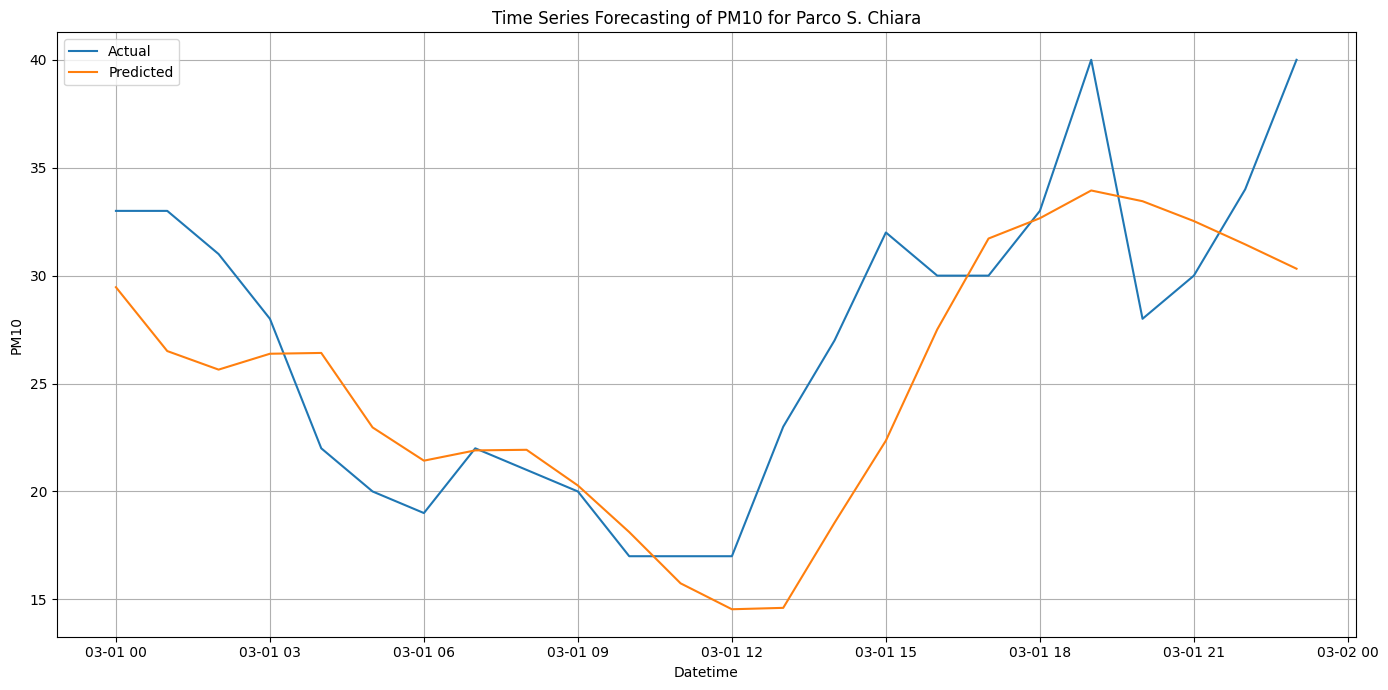

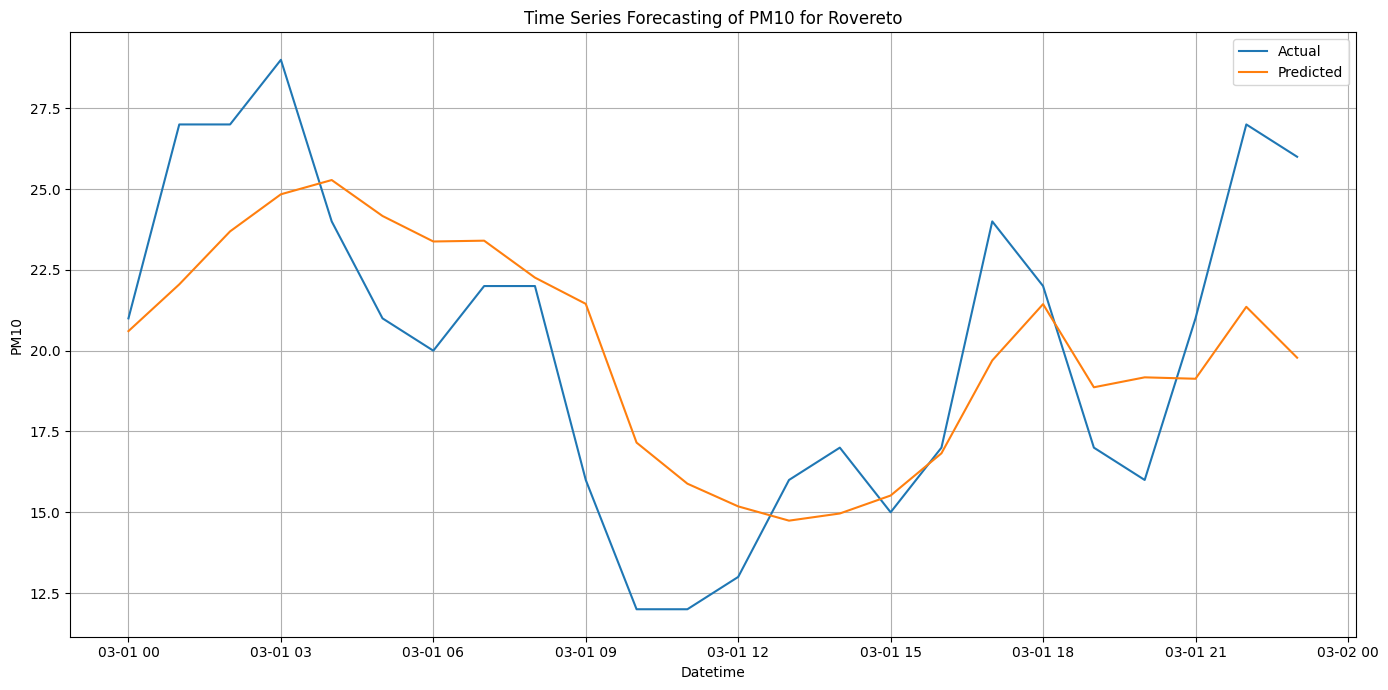

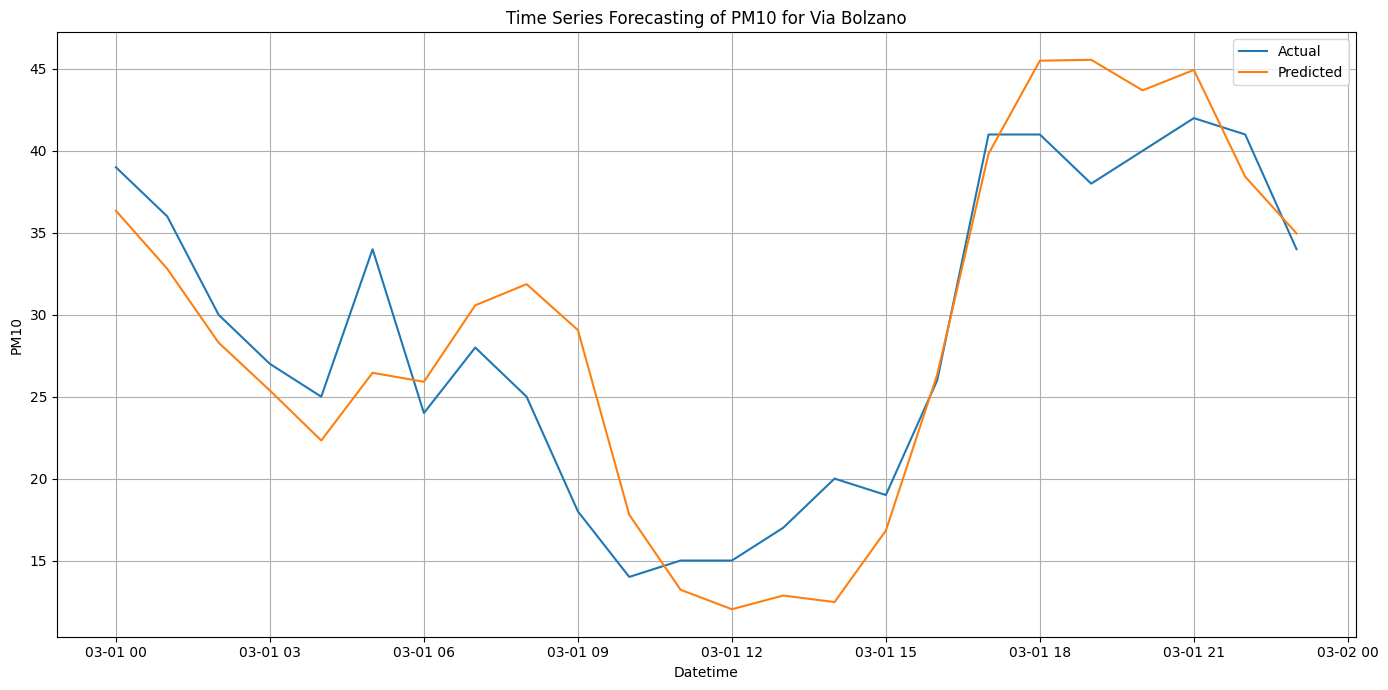

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate rolling average for smoother visualization
# window_size = 24 * 7 # 7 days rolling average

for station in stations_dfs.keys():
    y_test_station = y_test_dfs[station]
    predictions_station = predictions_dfs[station]
    test_station_df = test_dfs[station] # Get the original test dataframe for the index

    # Calculate rolling average for smoother visualization
    # y_test_rolling = y_test_station['PM10'].rolling(window=window_size).mean()
    # predictions_rolling = pd.Series(predictions_station, index=test_station_df.index).rolling(window=window_size).mean()


    plt.figure(figsize=(14, 7))
    plt.plot(test_station_df.index, y_test_station[f'{station}_PM10'], label='Actual')
    plt.plot(test_station_df.index, predictions_station, label='Predicted')

    plt.xlabel("Datetime")
    plt.ylabel("PM10")
    plt.title(f"Time Series Forecasting of PM10 for {station}")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


Calculating SHAP values for Parco S. Chiara...
Generating SHAP summary plot for Parco S. Chiara...


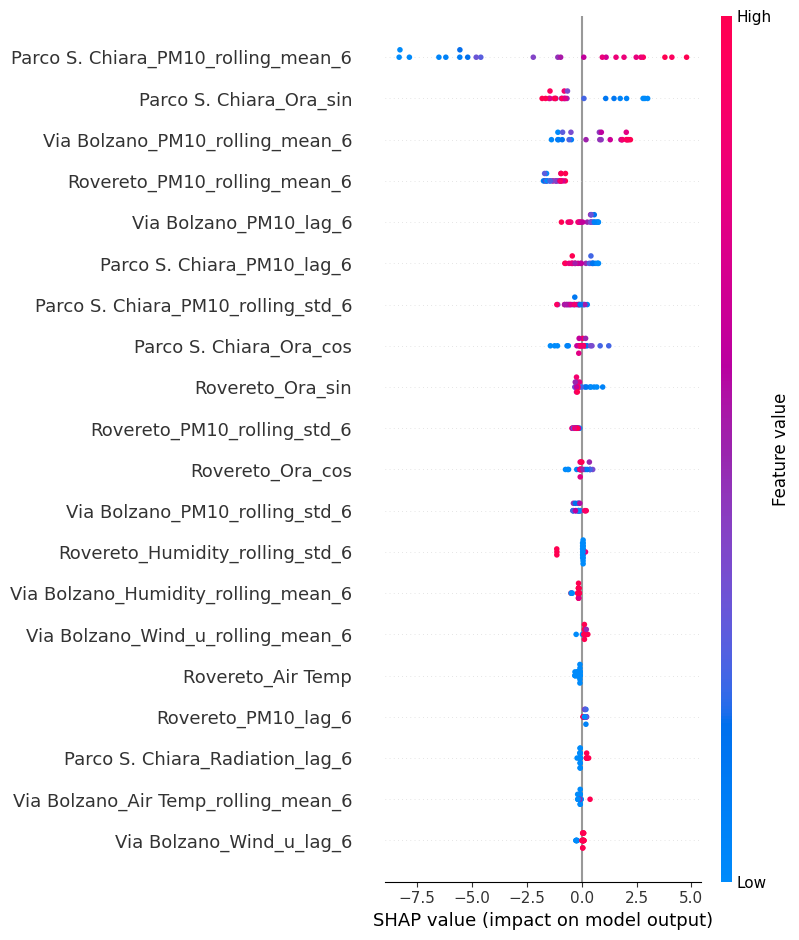


Calculating SHAP values for Rovereto...
Generating SHAP summary plot for Rovereto...


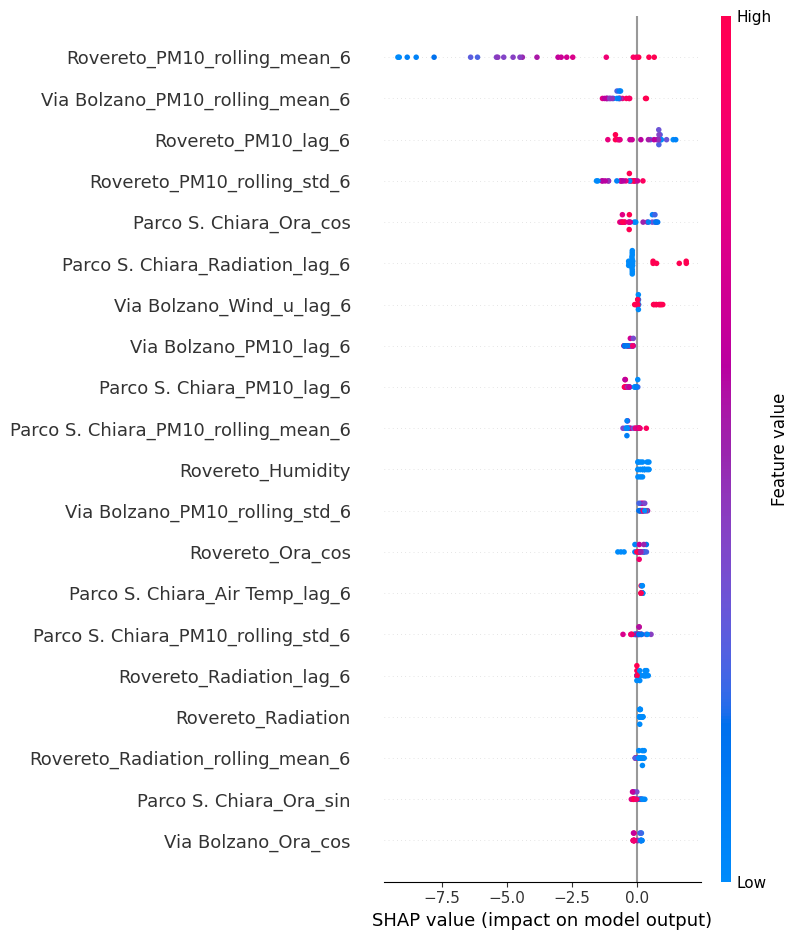


Calculating SHAP values for Via Bolzano...
Generating SHAP summary plot for Via Bolzano...


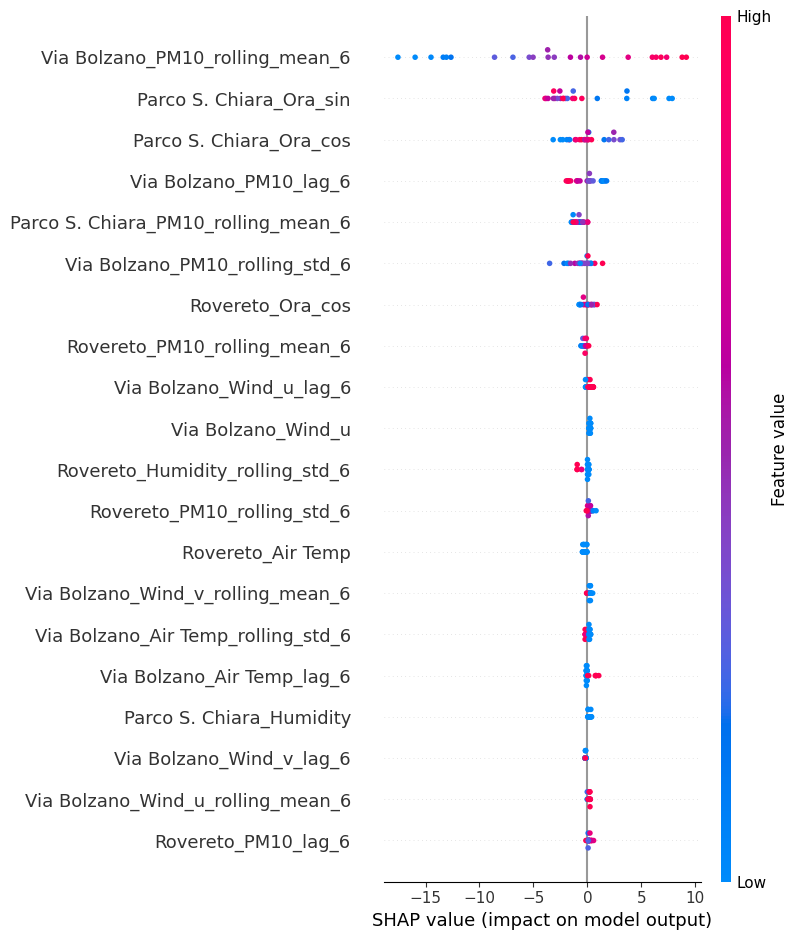


SHAP analysis complete for all stations.


In [ ]:
import shap

for station, model in trained_models.items():
    print(f"\nCalculating SHAP values for {station}...")
    # crea explainer
    explainer = shap.TreeExplainer(model, data=X_train_dfs[station], feature_perturbation="interventional")

    # calcola shap values su un campione di test (o su tutto, in batch)
    X_to_explain = X_test_dfs[station].sample(n=min(2000, len(X_test_dfs[station])), random_state=0)  # campione per plotting
    shap_values = explainer(X_to_explain, check_additivity=False)  # questo è veloce per TreeExplainer
    # shap_values.values è array (n_samples, n_features)

    # sv = pd.DataFrame(shap_values.values, columns=X_to_explain.columns, index=X_to_explain.index)
    # base_values = shap_values.base_values  # shape (n_samples,) o scalar

    print(f"Generating SHAP summary plot for {station}...")
    shap.summary_plot(shap_values.values, X_to_explain, feature_names=X_to_explain.columns)
    # oppure summary_plot(shap_values) con versione più recente di shap

print("\nSHAP analysis complete for all stations.")